In [ ]:
import argparse, pydicom
import torch
import numpy as np

from pathlib import Path
from typing import Any, Dict, Iterable, Tuple, List
from omegaconf import DictConfig, OmegaConf

import tg43.dicom_helper as dhelp
import tg43.contour_helper as chelp
import tg43.dose_calculation as dosecal
import tg43.utils as utils
import tg43.visualization as vis

In [ ]:
def load_hyperparams(config_path: Path) -> Tuple[DictConfig, Dict]:
    """Load MCO-IPSA hyperparameters from YAML and resolve runtime types."""

    cfg = OmegaConf.load(config_path)
    cfg_dict = OmegaConf.to_container(cfg, resolve=True)  # type: ignore[arg-type]
    return cfg

def resolve_single(path_iterable: Iterable[Path], description: str) -> Path:
    """Return the first path from ``path_iterable`` or raise if empty."""

    candidates = sorted(path_iterable)
    if not candidates:
        raise FileNotFoundError(f"No files found for {description}.")
    return candidates[0]

def load_case_paths(root: Path, case_id: int) -> Dict[str, Path]:
    """Collect CT, RTDOSE, RTPLAN, and RTSTRUCT paths for a case."""

    case_dir = root / f"{case_id}"
    if not case_dir.exists():
        raise FileNotFoundError(f"Case directory not found: {case_dir}")

    return {
        "ct": resolve_single(case_dir.glob("CT*/*"), "CT series"),
        "dose": resolve_single(case_dir.glob("RTDOSE*/*/*.dcm"), "RTDOSE file"),
        "plan": resolve_single(case_dir.glob("RTPLAN*/*/*.dcm"), "RTPLAN file"),
        "struct": resolve_single(case_dir.glob("RTSTRUCT*/*/*.dcm"), "RTSTRUCT file"),
    }

In [ ]:
cfg = load_hyperparams(Path("config.yaml"))
cfg

{'hyperparams': {'anisotropy_table': './ESTRO/nucletron_mhdr-v2_F.xlsx', 'radial_table': './ESTRO/nucletron_mhdr-v2_gL.xlsx', 'dose_max_cgy': 6000, 'dwell_time_mode': 'perturb', 'scale': 0.1}, 'models': {'dinov3': 'facebook/dinov3-vitb16-pretrain-lvd1689m'}, 'run': {'data-root': '/mnt/d/PRV/GYN_Geneva_wo_Needles', 'case': 'Case6'}}

In [ ]:
data_root = Path(cfg['run']['data-root'])
case_id = Path(cfg['run']['case'])
print(f"Data root: {data_root}")
print(f"Case ID: {case_id}")
paths = load_case_paths(data_root, case_id)
paths

Data root: /mnt/d/PRV/GYN_Geneva_wo_Needles
Case ID: Case6


{'ct': PosixPath('/mnt/d/PRV/GYN_Geneva_wo_Needles/Case6/CT_0_20240112/series_3_1.3.6.1.4.1.2452.6.1088874395.1296847118.3536313259.1264601617'),
 'dose': PosixPath('/mnt/d/PRV/GYN_Geneva_wo_Needles/Case6/RTDOSE_0_20240112/series_1_1.3.6.1.4.1.2452.6.2542691449.1298947939.3638676387.3704138358/ima_unknown_uid_1.3.6.1.4.1.2452.6.1444471091.1123319702.4073412502.1826252067.dcm'),
 'plan': PosixPath('/mnt/d/PRV/GYN_Geneva_wo_Needles/Case6/RTPLAN_0_20240112/series_1_1.3.6.1.4.1.2452.6.1356188019.1134003628.1522809736.1180775174/ima_empty_uid_1.3.6.1.4.1.2452.6.3162210145.1093853173.1113596587.2422958571.dcm'),
 'struct': PosixPath('/mnt/d/PRV/GYN_Geneva_wo_Needles/Case6/RTSTRUCT_0_20240112/series_1_1.3.6.1.4.1.2452.6.3775943779.1152257382.1983088276.1409971453/ima_empty_uid_1.3.6.1.4.1.2452.6.3039571248.1233624635.2885846168.1640366842.dcm')}

In [ ]:
import src.dataloader as dataloader
import importlib
importlib.reload(dataloader)

case = dataloader.load_case(paths, cfg)
ct_slices = case["ct_slices"]   

(160, 512, 512)
(160, 512, 512)
(160, 512, 512, 5)


In [ ]:
case["ct_slices"].shape, case["dose_slices"].shape, case["mask_slices"].shape, case["dwell_positions"].shape

((19, 512, 512), (19, 512, 512), (19, 512, 512, 5), (19, 3))

In [ ]:
case["dwell_positions"]

array([[274, 241,  95],
       [274, 243,  92],
       [277, 231, 107],
       [282, 247,  83],
       [262, 252,  84],
       [282, 253,  84],
       [273, 247,  88],
       [262, 241,  81],
       [278, 227, 111],
       [277, 229, 109],
       [262, 246,  83],
       [273, 245,  90],
       [276, 235, 102],
       [275, 237, 100],
       [262, 257,  85],
       [275, 239,  97],
       [282, 243,  81],
       [281, 259,  84],
       [276, 233, 104]])

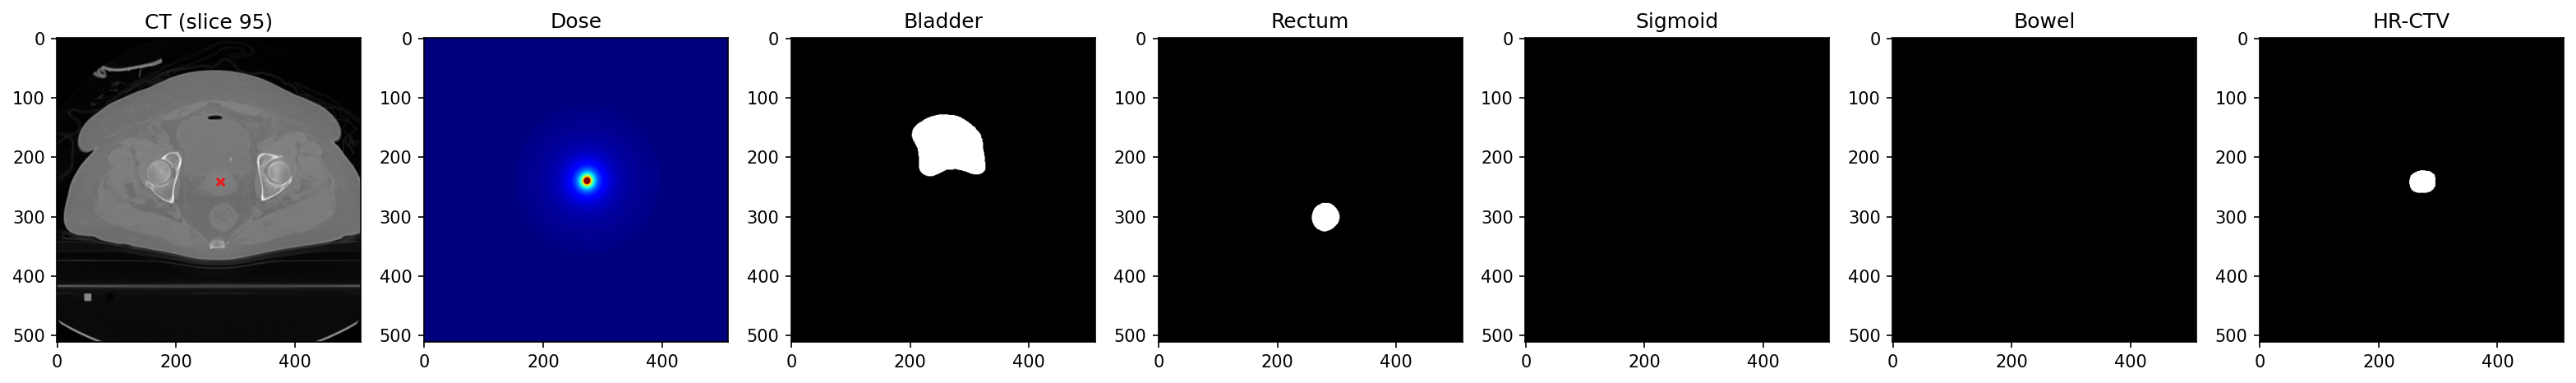

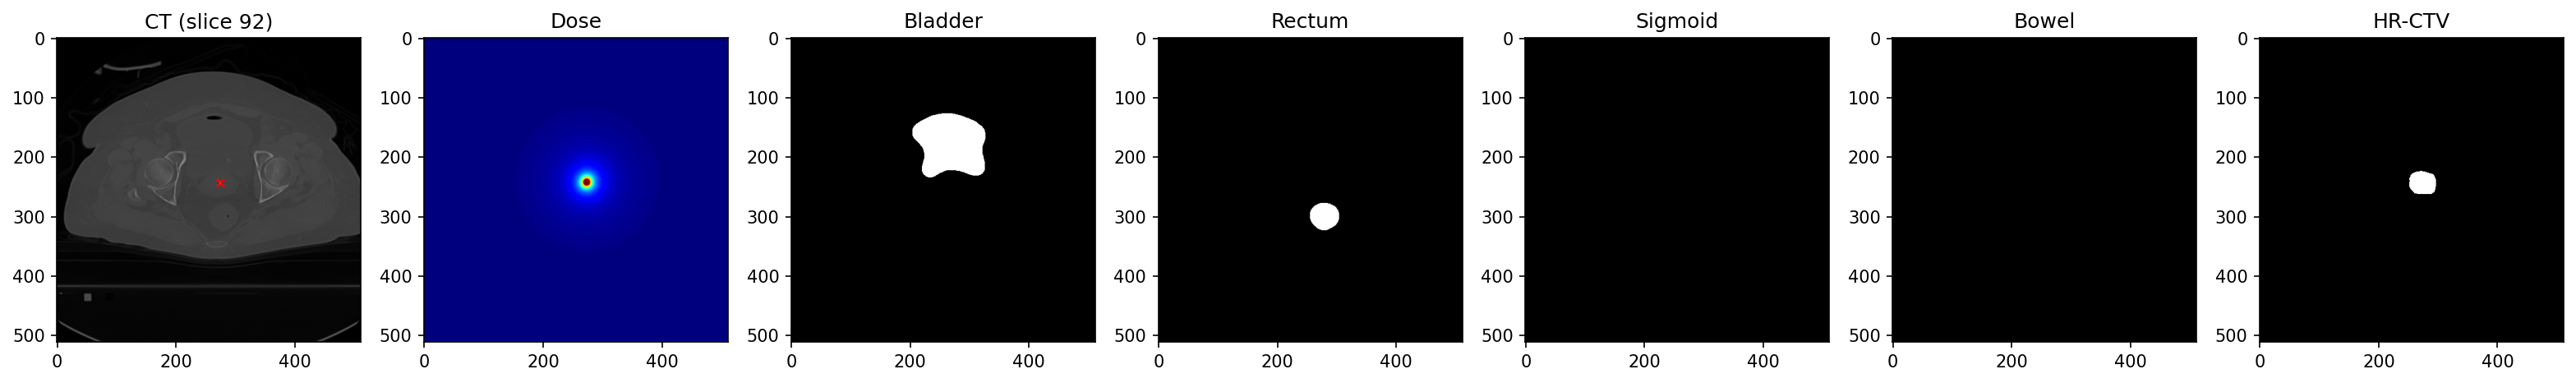

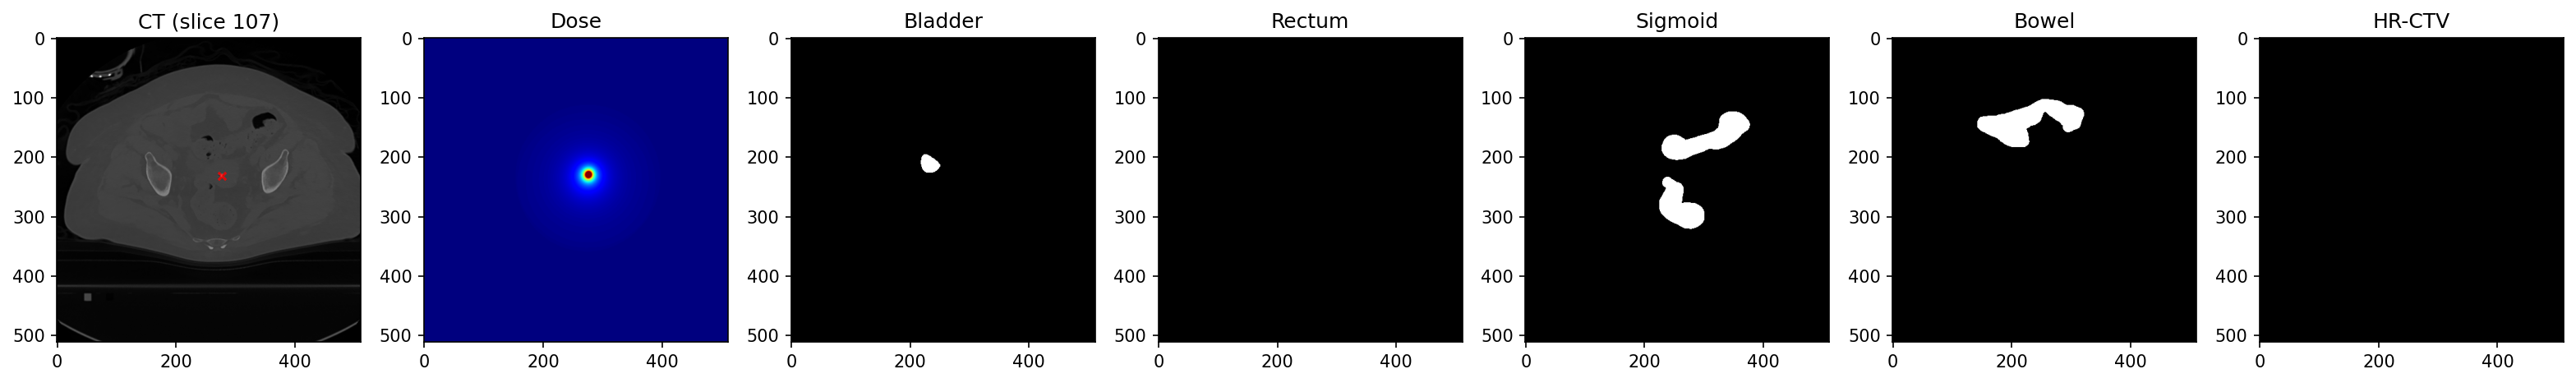

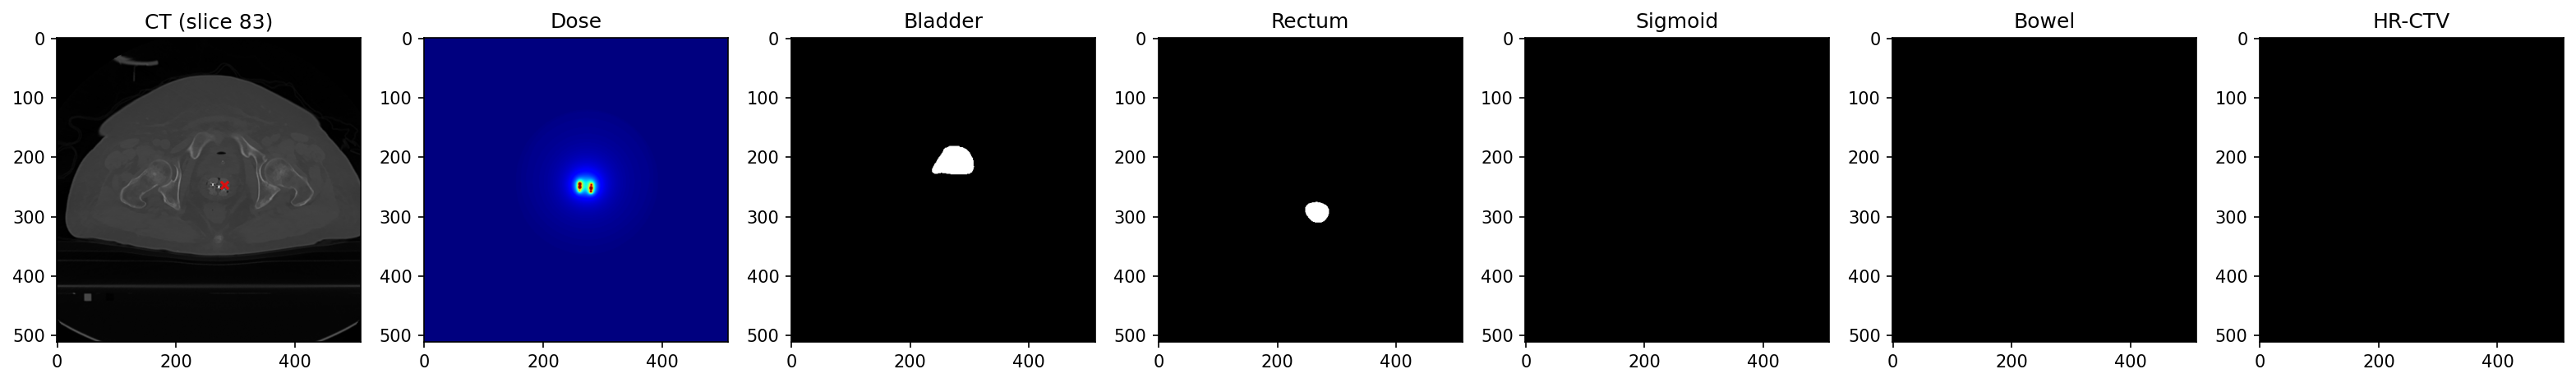

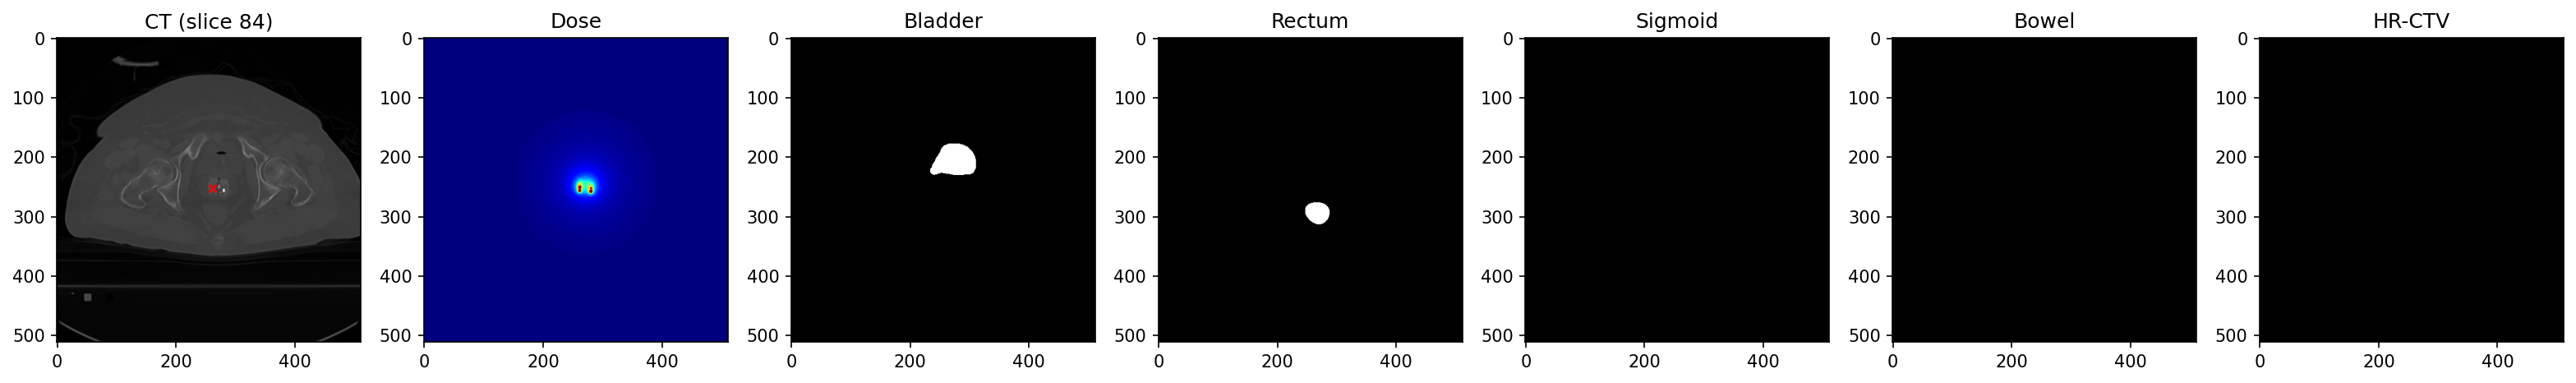

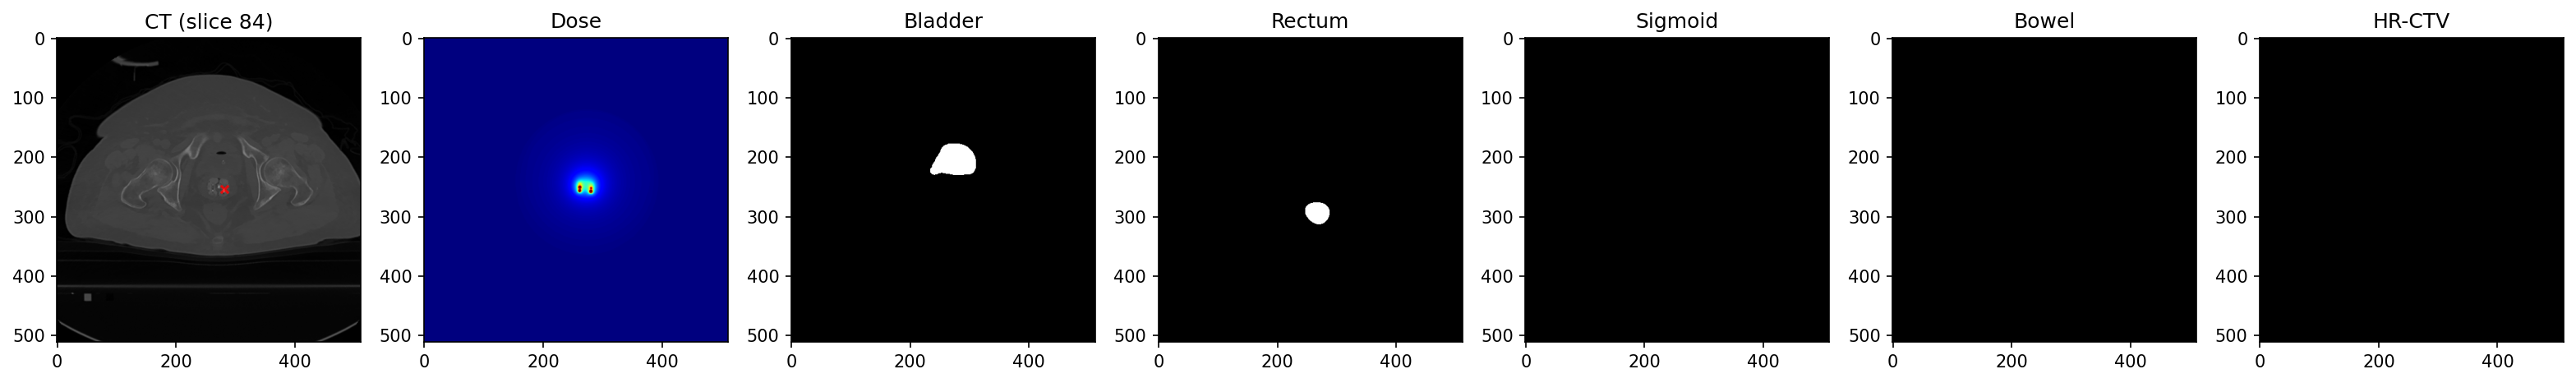

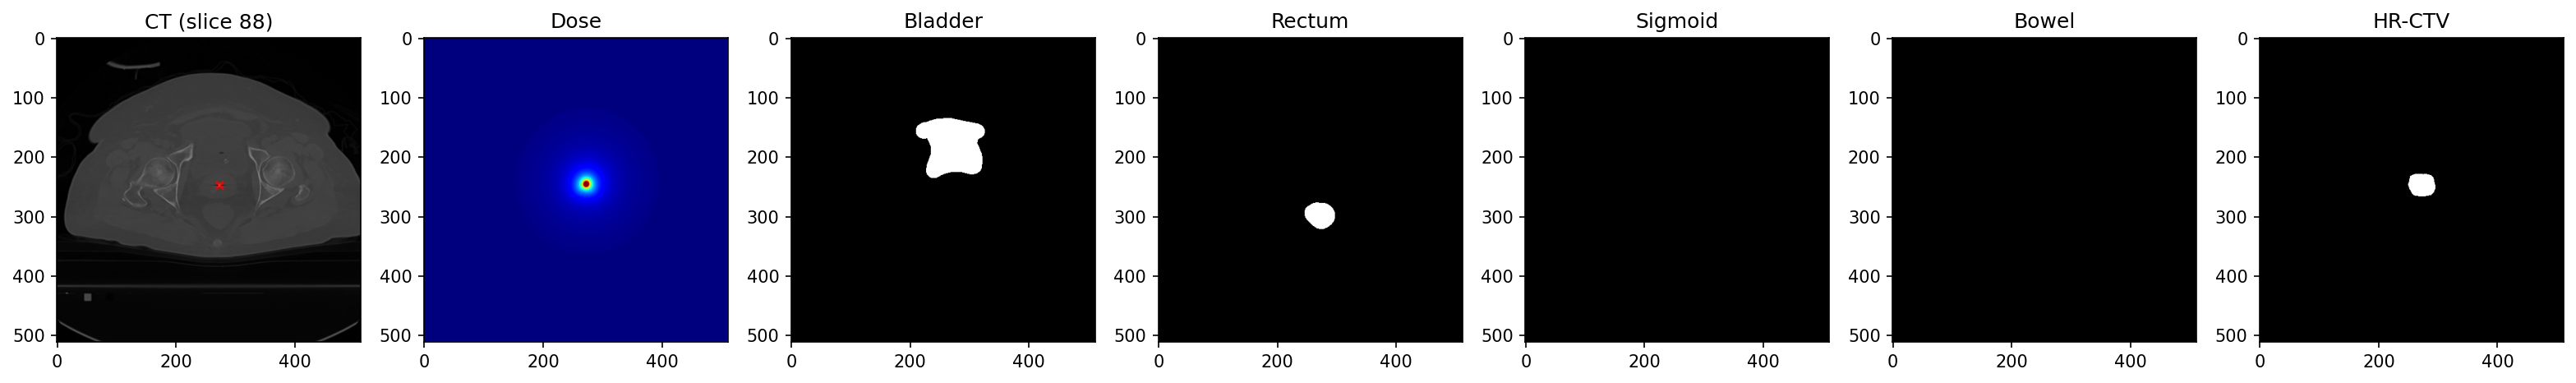

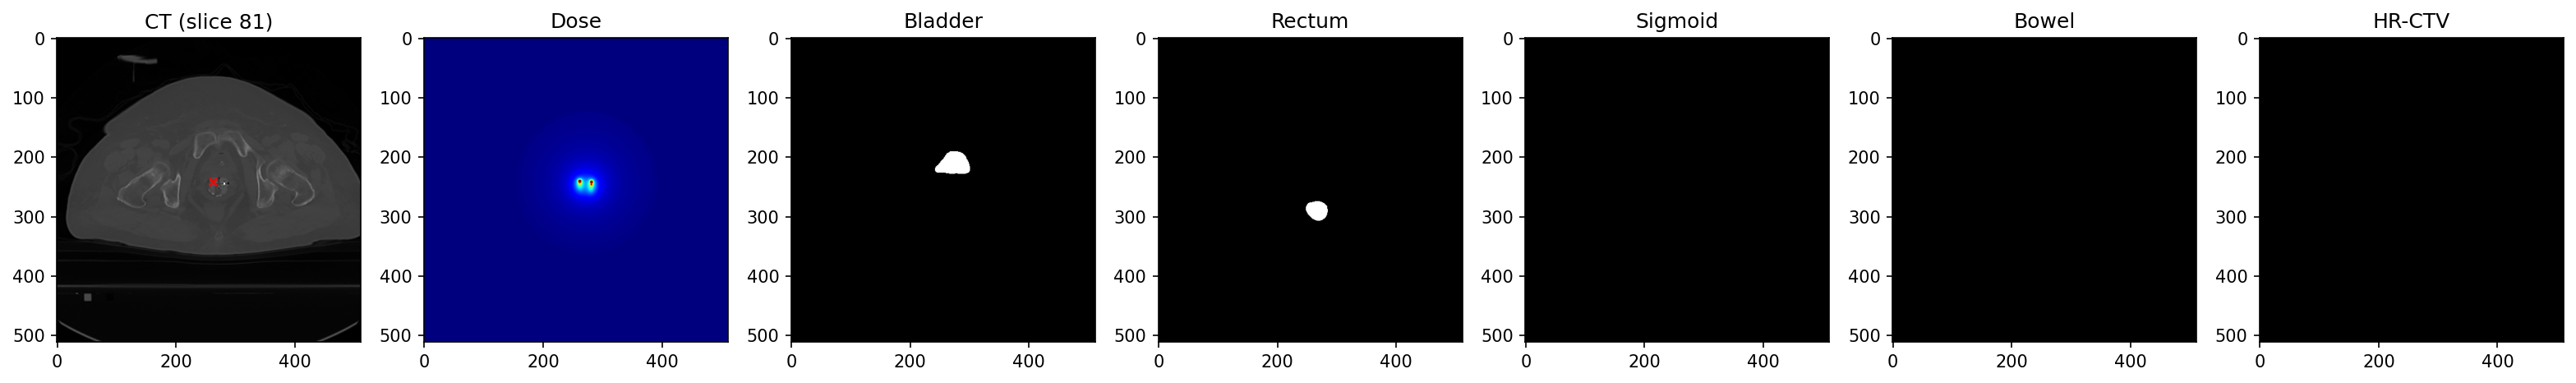

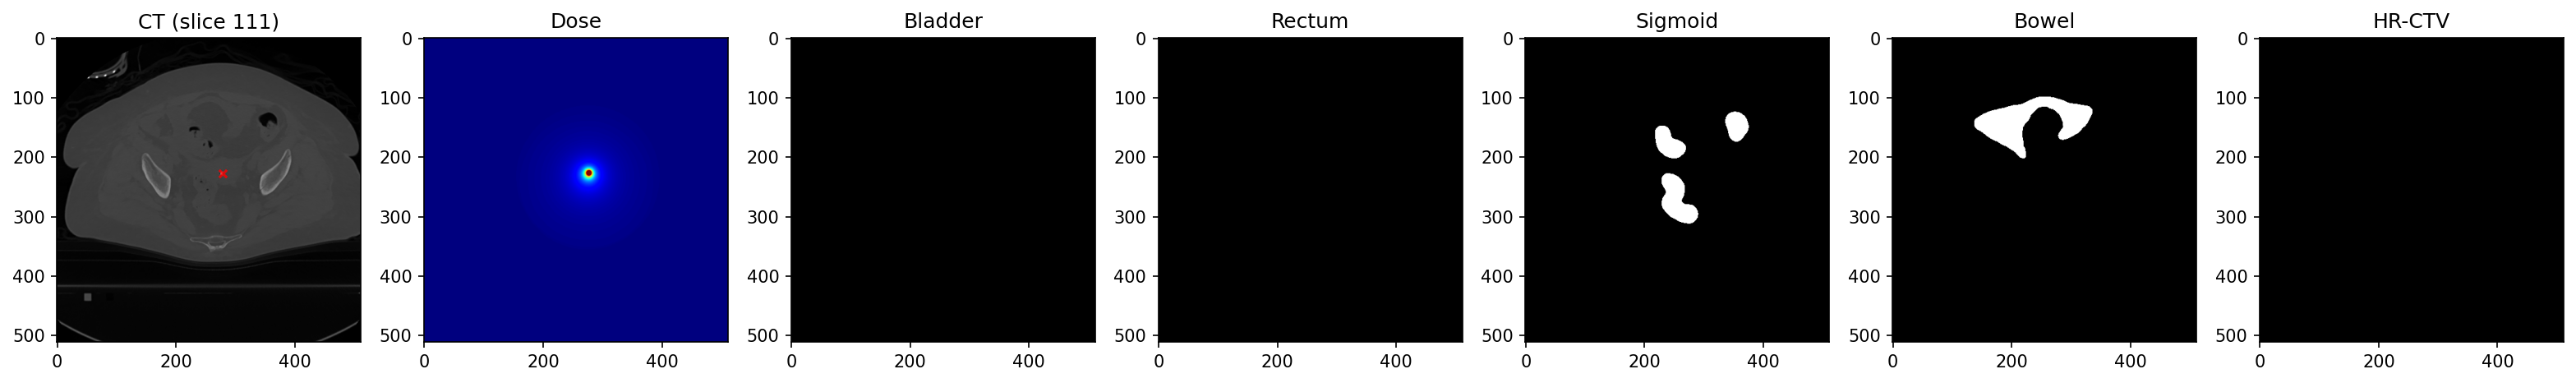

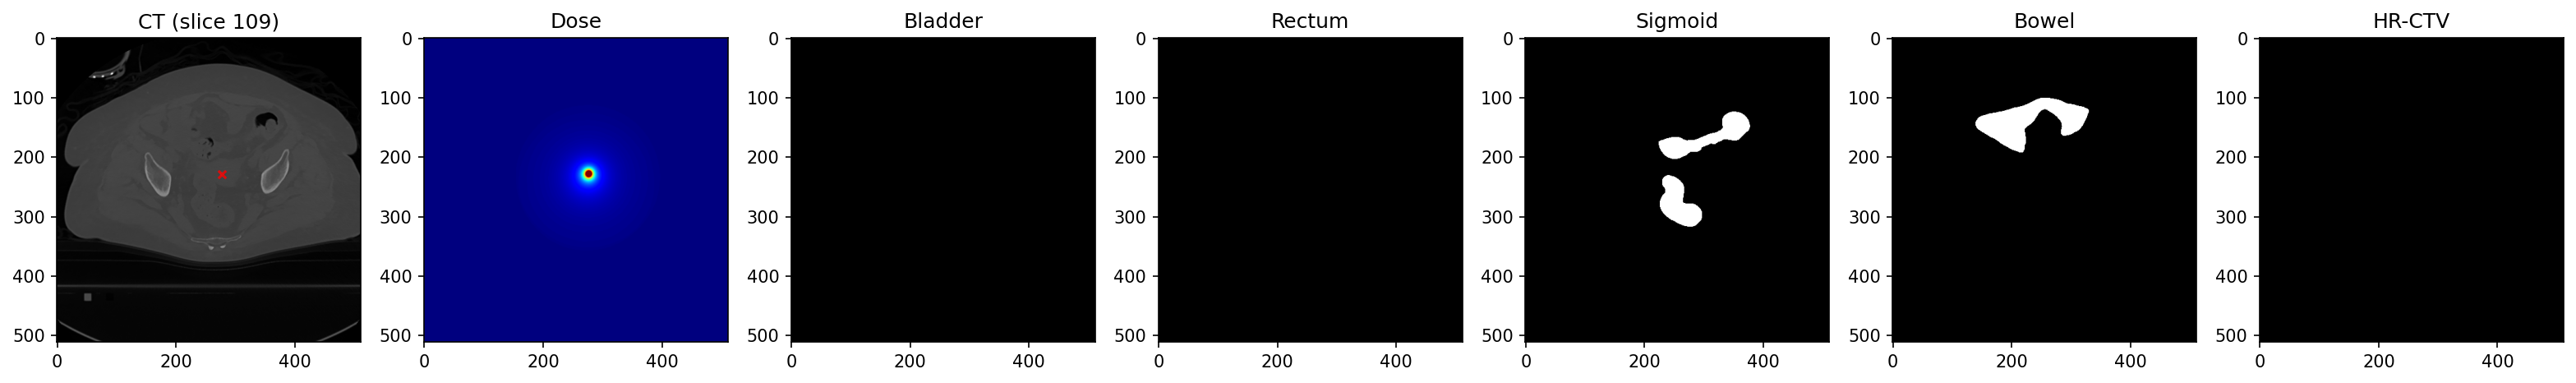

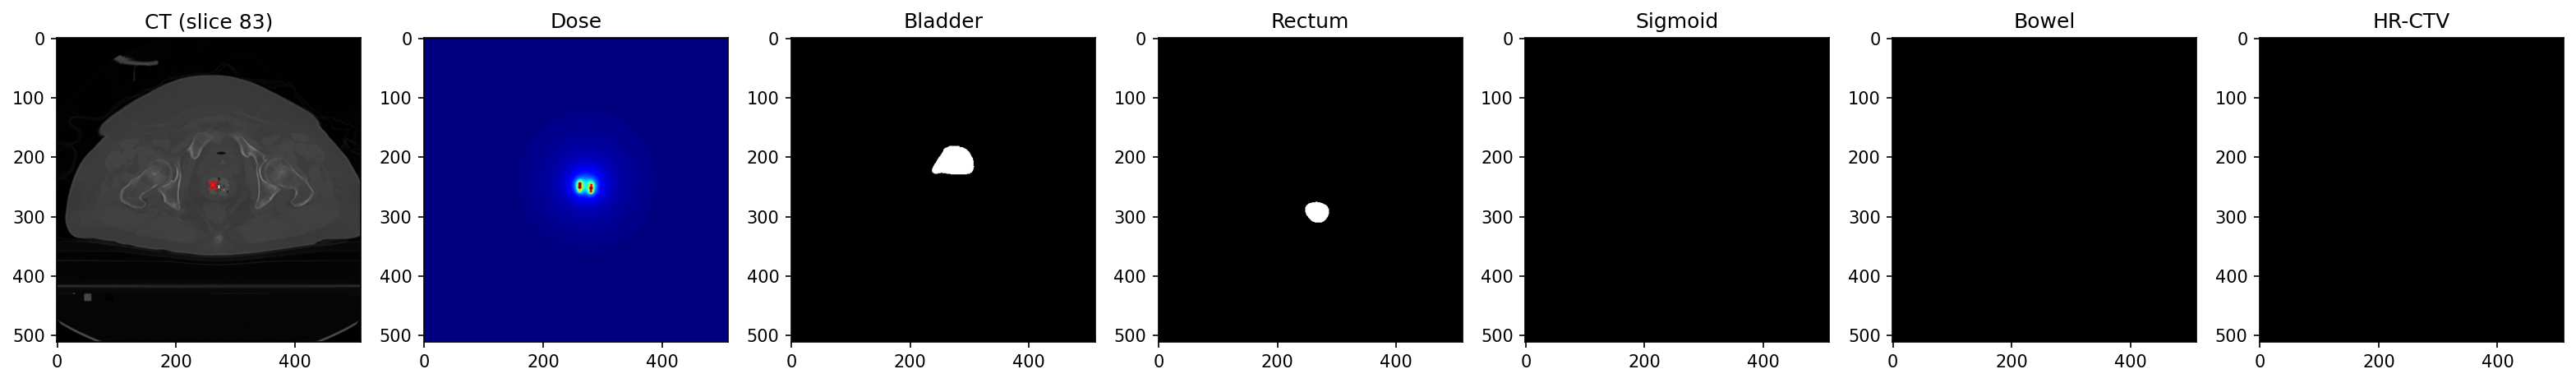

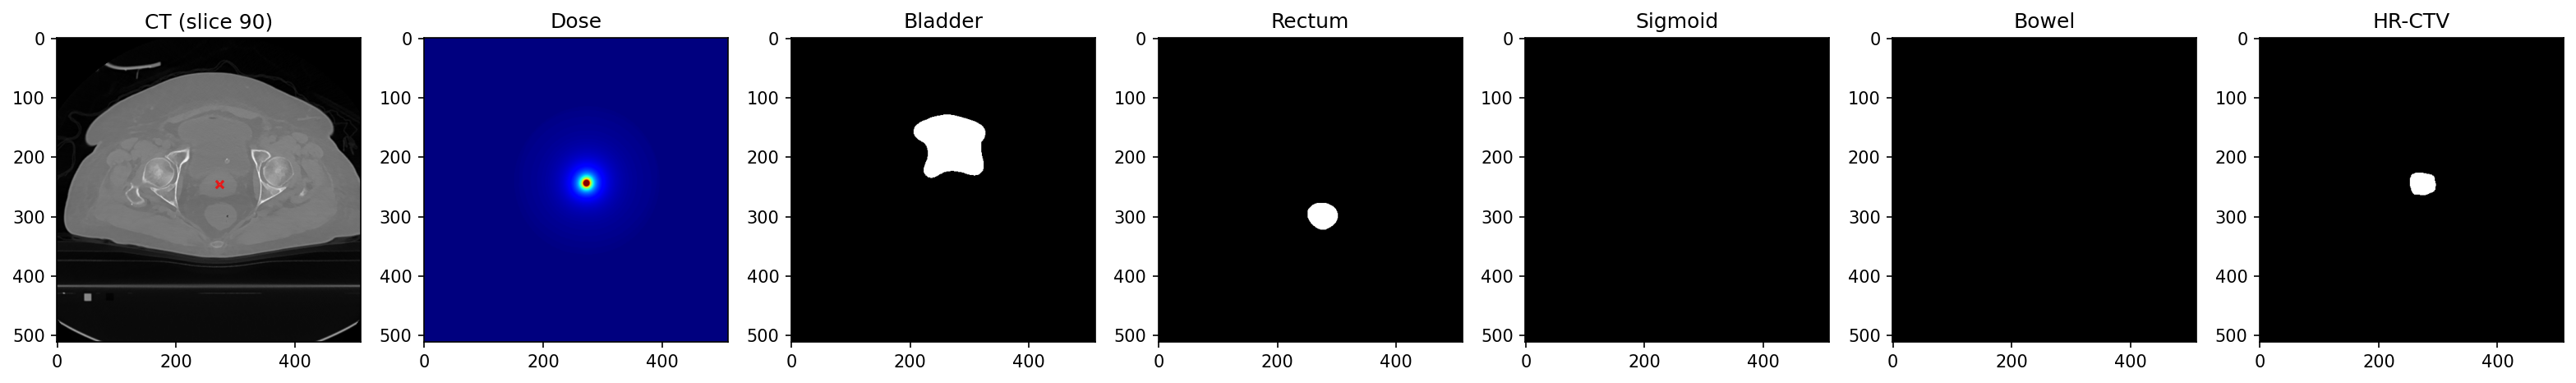

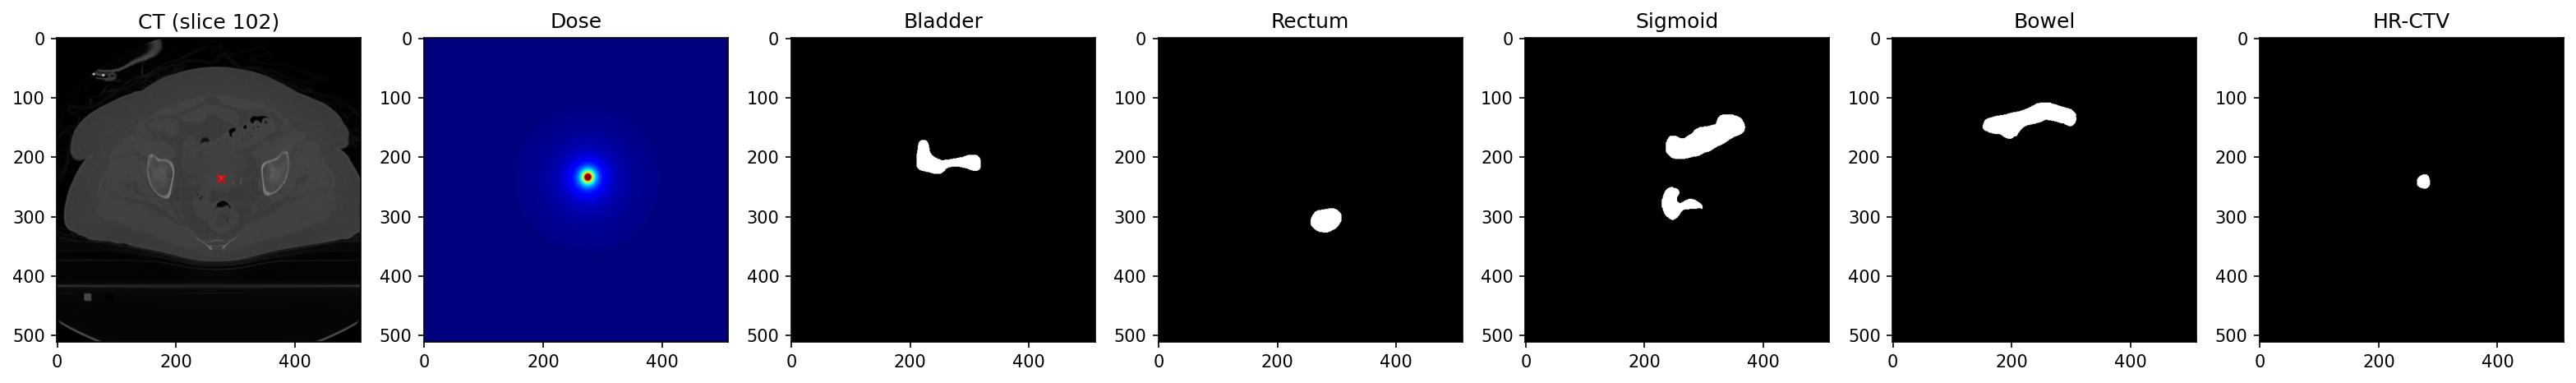

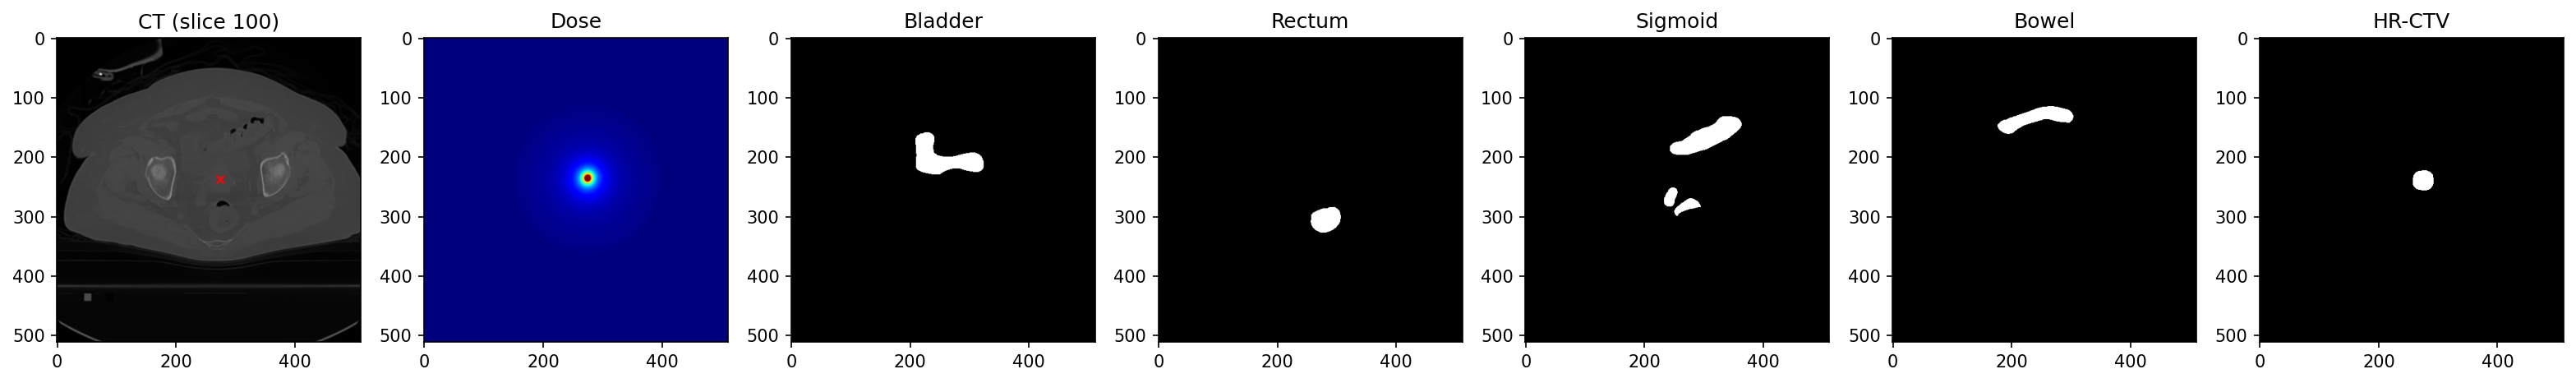

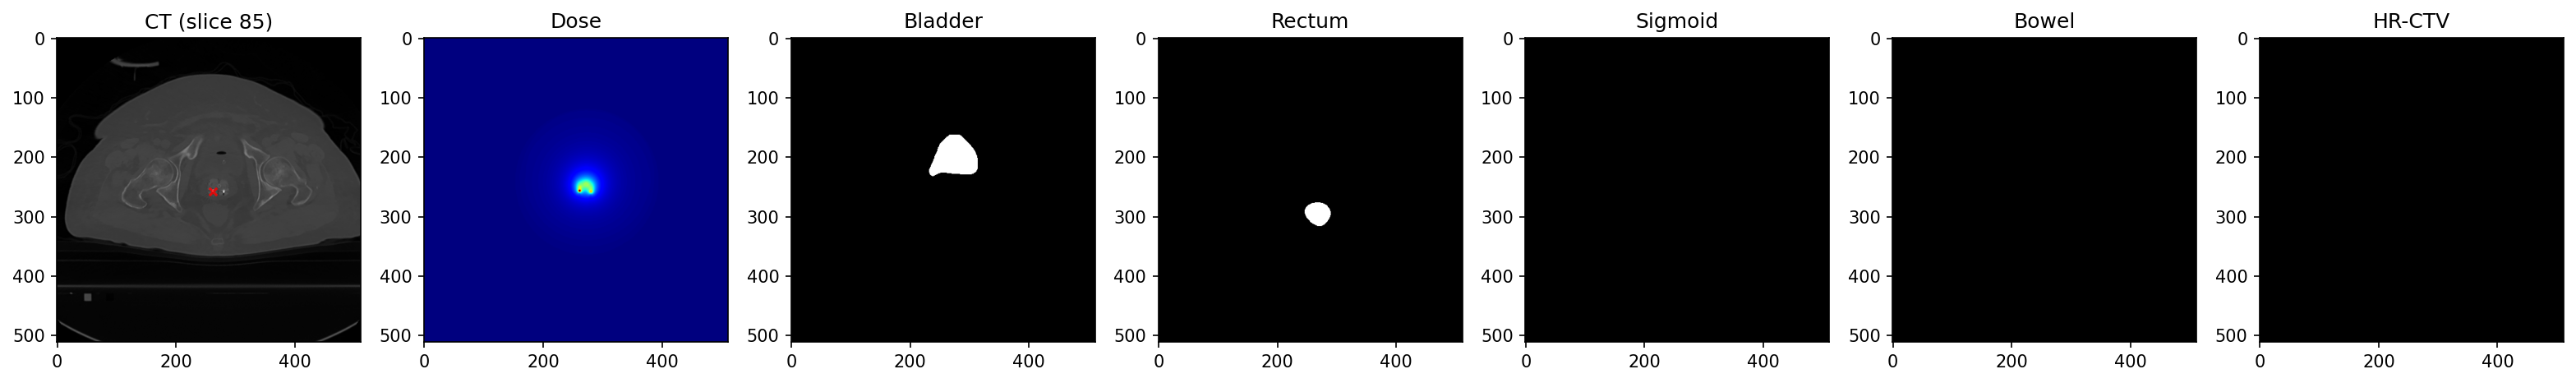

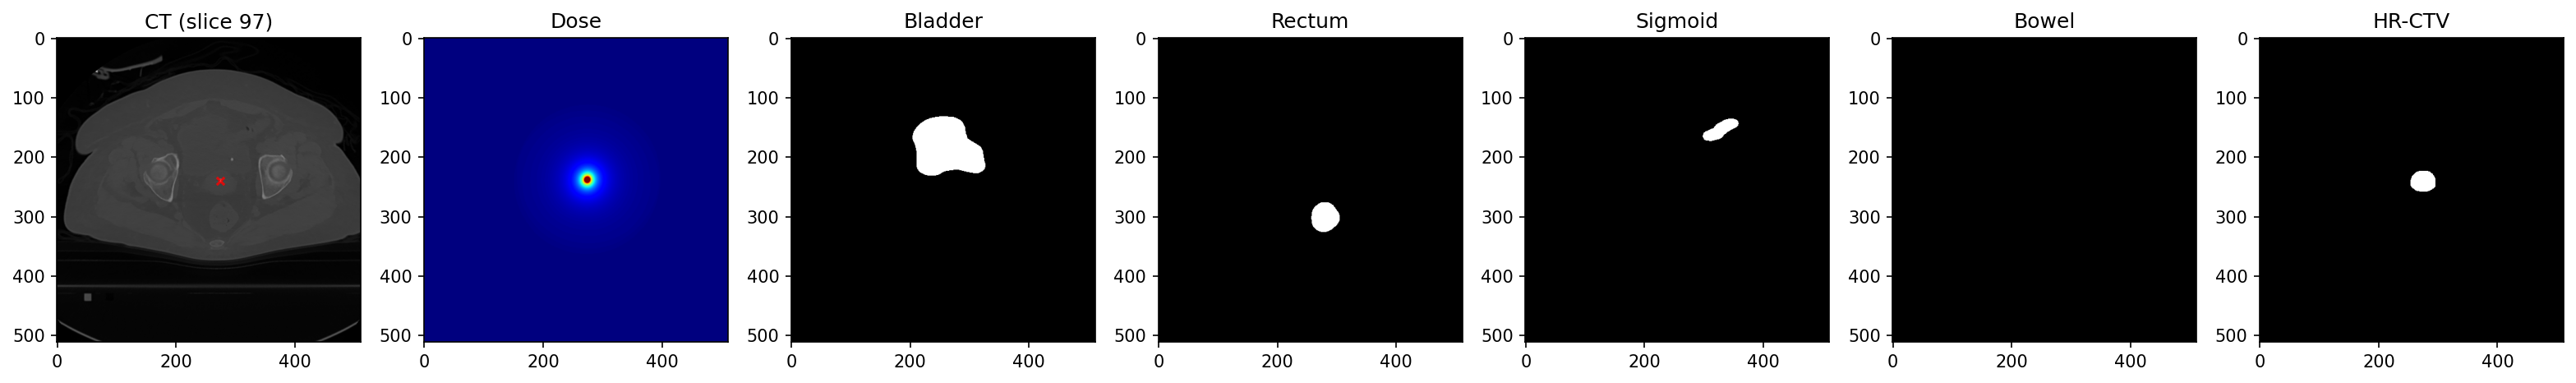

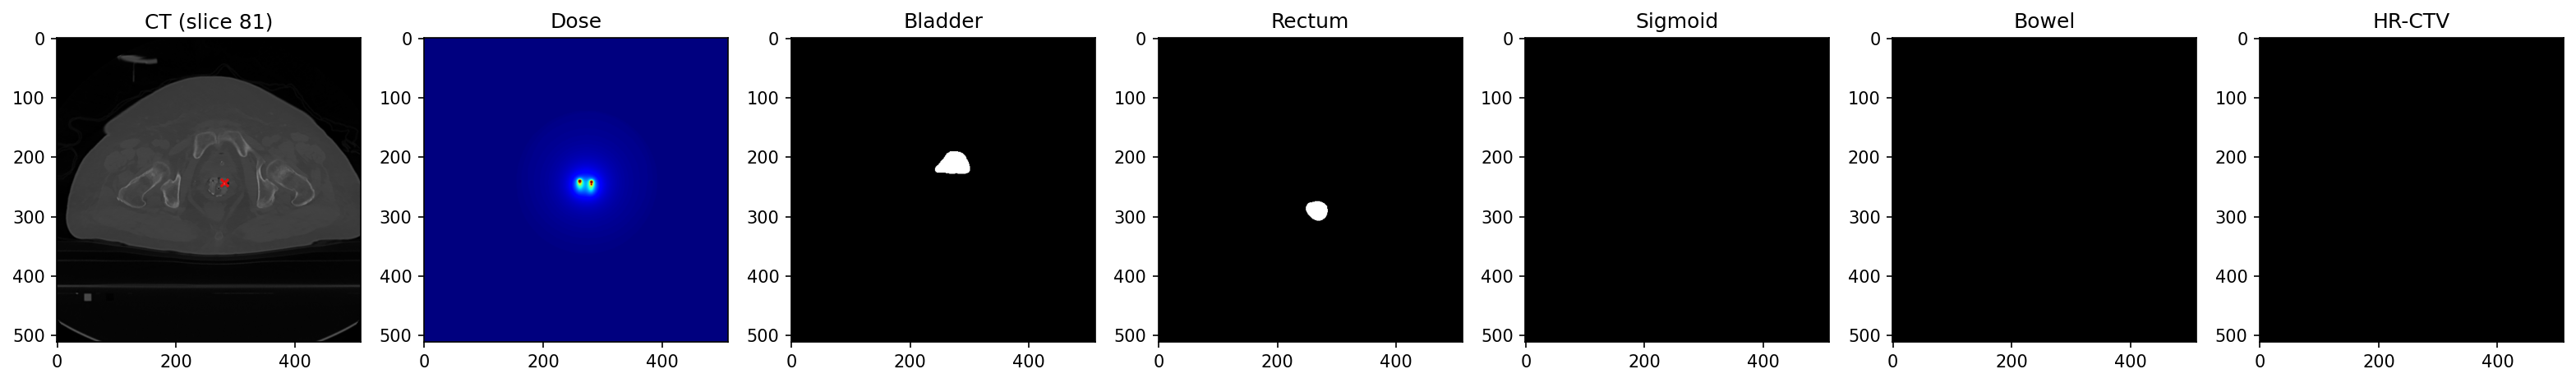

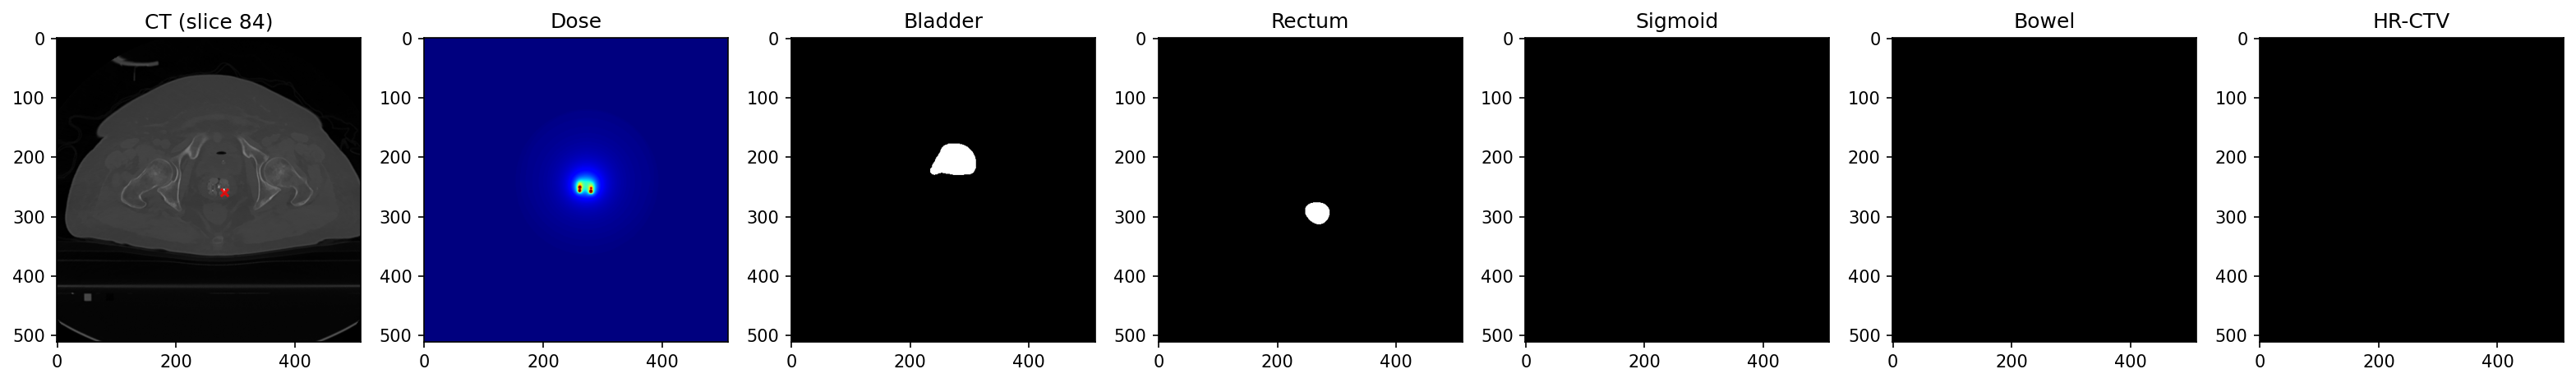

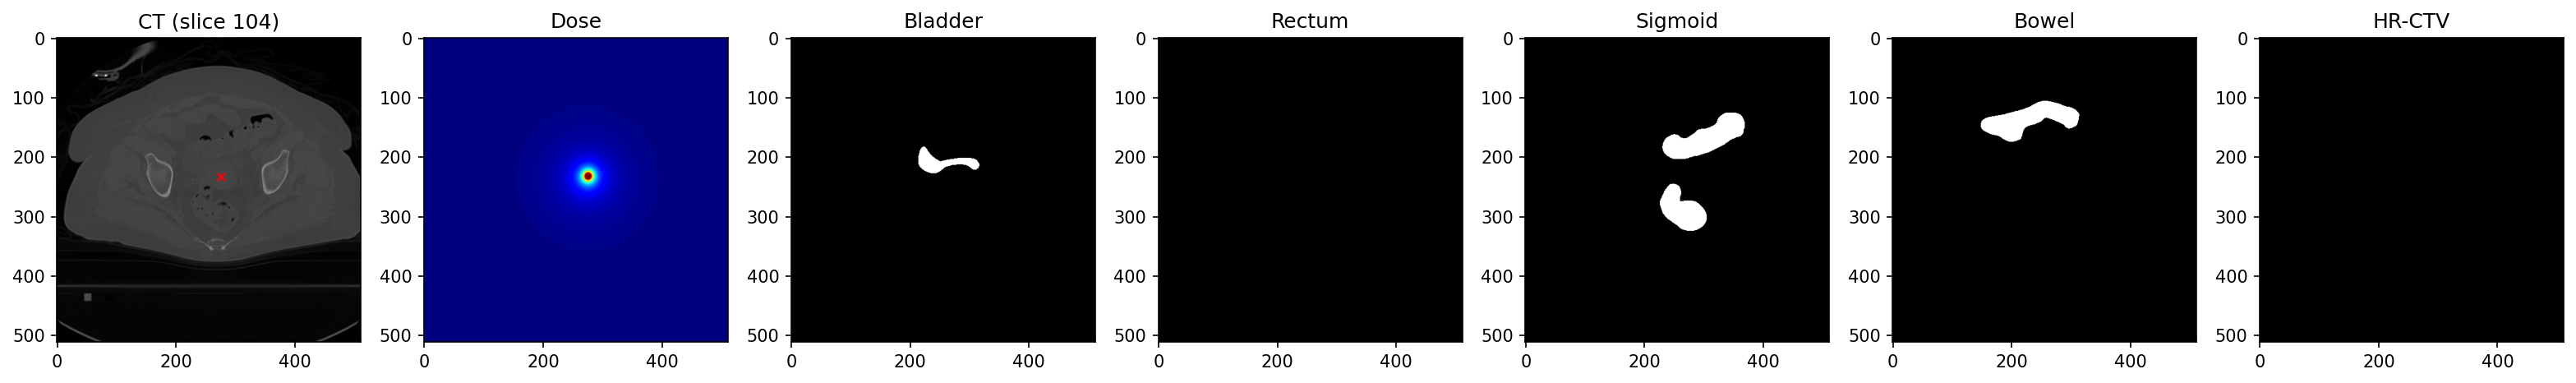

In [ ]:
import matplotlib.pyplot as plt

num_mask = case["mask_slices"].shape[-1]

for idx_sample in range(len(case['dwell_positions'])):

    fig, axes = plt.subplots(1, 2+num_mask, figsize=(3*(2+num_mask), 3), dpi=150)
    
    coordinate = case['dwell_positions'][idx_sample]
    axes[0].set_title(f"CT (slice {coordinate[-1]})")
    axes[0].imshow(case["ct_slices"][idx_sample], cmap='gray')
    axes[0].scatter(coordinate[0], coordinate[1], c='red', s=20, marker='x', alpha=0.8)

    axes[1].set_title("Dose")
    axes[1].imshow(utils.dose_clip(case["dose_slices"][idx_sample], 4000), cmap='jet')
    for idx_mask in range(num_mask):
        axes[2+idx_mask].set_title(f"{case['mask_names'][idx_mask]}")
        axes[2+idx_mask].imshow(case["mask_slices"][idx_sample, ..., idx_mask], cmap='gray')

    plt.tight_layout()
    plt.show()

[[252 281]
 [245 262]
 [251 262]
 [258 281]]
282 -> 281 ||| 247 -> 252


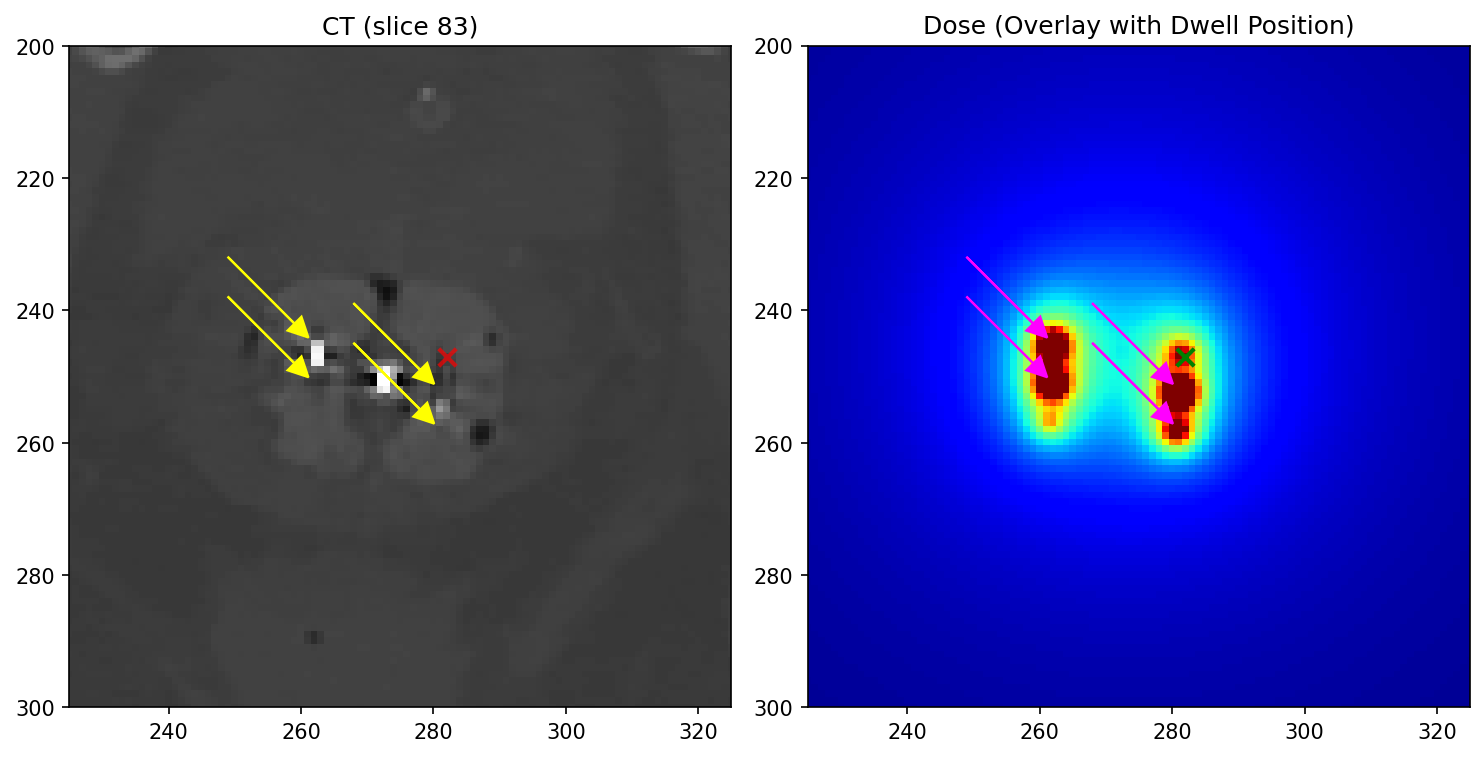

In [ ]:
idx_sample = 3
coordinate = case['dwell_positions'][idx_sample]

peaks = case["dwell_candidates"][idx_sample]
x, y, z = coordinate


num_mask = case["mask_slices"].shape[-1]
arrow_length = 10
arrow_size = 3

fig, axes = plt.subplots(1, 2, figsize=(5*2, 5), dpi=150)

coordinate = case['dwell_positions'][idx_sample]
axes[0].set_title(f"CT (slice {coordinate[-1]})")
axes[0].imshow(case["ct_slices"][idx_sample], cmap='gray')
axes[0].scatter(coordinate[0], coordinate[1], c='red', marker='x', s=70, linewidths=2, alpha=0.7)
for peak in peaks:
    x_pred, y_pred = peak
    # axes[0].scatter(x_pred, y_pred, c='yellow', s=20, marker='x', linewidths=0.75, alpha=1.0)
    axes[0].arrow(x_pred-(arrow_length+arrow_size), y_pred-(arrow_length+arrow_size), arrow_length, arrow_length, width=0.05, color='yellow', head_width=arrow_size, head_length=arrow_size)
axes[0].set_xlim(225, 325)
axes[0].set_ylim(300, 200)

axes[1].set_title("Dose (Overlay with Dwell Position)")
axes[1].imshow(utils.dose_clip(case["dose_slices"][idx_sample], 4000), cmap='jet')
axes[1].scatter(coordinate[0], coordinate[1], c='green', marker='x', s=70, linewidths=2, alpha=1)
for peak in peaks:
    x_pred, y_pred = peak
    # axes[1].scatter(x_pred, y_pred, s=30, facecolors='none', edgecolors='magenta', linewidths=0.75)
    axes[1].arrow(x_pred-(arrow_length+arrow_size), y_pred-(arrow_length+arrow_size), arrow_length, arrow_length, width=0.05, color='magenta', head_width=arrow_size, head_length=arrow_size)
axes[1].set_xlim(225, 325)
axes[1].set_ylim(300, 200)

plt.tight_layout()
plt.show()